In [60]:
import sys
import pickle
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

pd.options.display.max_rows = 199
pd.options.display.max_columns = 99

%matplotlib inline

In [61]:
data_dict = pickle.load(open('final_project_dataset.pkl'))

#### Remove Bad Samples

In [62]:
bad_keys = ['TOTAL','LOCKHART EUGENE E','THE TRAVEL AGENCY IN THE PARK']
for i in bad_keys:
    if i in data_dict:
        del data_dict[i]

#### Fill NaNs

In [63]:
df = pd.DataFrame.from_dict(data_dict,orient='index')
df = df.replace('NaN',-999)

In [55]:
df.shape

(143, 21)

#### Add New Features

In [64]:
df['message_ratio'] = df['to_messages']/df['from_messages']
df['poi_from_ratio'] = df['from_poi_to_this_person']/df['from_messages']
df['poi_to_ratio'] = df['from_this_person_to_poi']/df['to_messages']
df['deferred_ratio'] = df['deferral_payments']/df['total_payments']

#### Splitting Data For Testing

In [66]:
target = df['poi'].astype(int)
predictors = df.drop(['poi','email_address'],axis=1)
x = np.array(predictors).tolist()
y = np.array(target).tolist()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)

#### Feature Selection

In [96]:
clf = RandomForestClassifier(max_features='sqrt',n_estimators=50)
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [97]:
pred = clf.predict(x_test)

In [98]:
clf.feature_importances_

array([  5.88324546e-02,   4.54395124e-02,   9.68043469e-03,
         4.88838694e-02,   6.01404621e-02,   7.20181487e-02,
         4.98471577e-02,   5.63109923e-02,   0.00000000e+00,
         9.04688862e-02,   8.00594876e-02,   0.00000000e+00,
         2.23333378e-02,   1.07346427e-01,   1.98679673e-02,
         9.15569146e-05,   5.13682150e-02,   3.38967032e-02,
         2.87677640e-02,   7.28272782e-02,   2.46999024e-02,
         2.83623633e-02,   3.87570796e-02])

In [99]:
features = DataFrame()
features['Feature_Names'] = predictors.columns
features['Feature_Importance'] = clf.feature_importances_

In [100]:
features.sort(columns='Feature_Importance', ascending=False)

,Feature_Names,Feature_Importance
13,other,0.107346
9,total_stock_value,0.090469
10,expenses,0.080059
19,message_ratio,0.072827
5,bonus,0.072018
4,exercised_stock_options,0.060140
0,salary,0.058832
7,shared_receipt_with_poi,0.056311
16,deferred_income,0.051368
6,restricted_stock,0.049847


In [21]:
pca = PCA()
selection = SelectKBest()
combined_features = F
eatureUnion([('pca',pca),('univ_select',selection)])

#### Split Data For Testing

In [22]:
target = df['poi'].astype(int)
predictors = df.drop(['poi','email_address'],axis=1)
x = np.array(predictors).tolist()
y = np.array(target).tolist()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)

#### SVC

In [23]:
clf = LogisticRegression()

In [24]:
pipeline = Pipeline([('features', combined_features),('logistic',clf)])

In [37]:
scores = ['precision', 'recall']
param_grid = dict(features__pca__n_components = [1,2,3,4,5,6,7,8],
                 features__univ_select__k=[1,2,3,4,5,6,7,8,9,10],
                 logistic__C=[0.1, 1, 10])

In [39]:
for score in scores:
    print "# Tuning hyper-parameters for %s" % score
    print ()
    clf = GridSearchCV(pipeline, param_grid=param_grid, scoring='%s_weighted' % score, verbose=10)
    clf.fit(x_train, y_train)
    print "Best parameters set found on development set:"
    print ()
    print clf.best_params_
    print ()

# Tuning hyper-parameters for precision
()
Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1, score=0.755602 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1, score=0.768939 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1, score=0.801347 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=1, score=0.755602 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=1 

[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    0.1s



[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=1, score=0.768939 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=1, score=0.801347 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=1, score=0.755602 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=1, score=0.768939 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=1, score=0.801347 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=2 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select_

[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:    0.2s



[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=2 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=2, score=0.878788 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=3 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=3, score=0.791904 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=3 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=3, score=0.917614 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=3 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=3, score=0.761616 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=3 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=3, score=0.791904 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_sele

[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.4s



[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=4, score=0.715370 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=4 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=4, score=0.917614 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=4 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=4, score=0.818182 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=4 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=4, score=0.715370 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=4 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=4, score=0.917614 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=4 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select_

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.4s
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=5, score=0.710784 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=5, score=0.917614 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=5, score=0.808874 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=6 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=6, score=0.710784 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=6 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=6, score=0.772268 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_se

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  60 tasks       | elapsed:    0.7s



[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=7 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=7, score=0.715370 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=7 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=7, score=0.768939 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=7 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=7, score=0.896936 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=7 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=7, score=0.715370 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=7 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=7, score=0.768939 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=7 


[Parallel(n_jobs=1)]: Done  71 tasks       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  84 tasks       | elapsed:    0.9s



[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=10 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=10, score=0.882576 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=10 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=10, score=0.764706 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=10 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=10, score=0.831313 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=10 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=10, score=0.882576 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=10 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=10, score=0.764706 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_s

[Parallel(n_jobs=1)]: Done  97 tasks       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 112 tasks       | elapsed:    1.2s



[CV]  logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=3, score=0.917614 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=3 
[CV]  logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=3, score=0.854350 -   0.0s
[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=3 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=3, score=0.719669 -   0.0s
[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=3 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=3, score=0.917614 -   0.0s
[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=3 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=3, score=0.854350 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=3 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 144 tasks       | elapsed:    1.5s



[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=6, score=0.808874 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=6 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=6, score=0.710784 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=6 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=6, score=0.768939 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=6 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=6, score=0.808874 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=7 
[CV]  logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=7, score=0.710784 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=7 
[CV]  logistic__C=0.1, features__pca__n_components=2, features__univ_sel

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 180 tasks       | elapsed:    1.9s



[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=10 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=10, score=0.882576 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=10 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=10, score=0.710784 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=10 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=10, score=0.831313 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=10 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=10, score=0.882576 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=1, score=0.719669 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__uni

[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 220 tasks       | elapsed:    2.3s



[CV] logistic__C=1, features__pca__n_components=3, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=3, features__univ_select__k=5, score=0.772268 -   0.0s
[CV] logistic__C=1, features__pca__n_components=3, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=3, features__univ_select__k=5, score=0.748597 -   0.0s
[CV] logistic__C=10, features__pca__n_components=3, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=3, features__univ_select__k=5, score=0.715370 -   0.0s
[CV] logistic__C=10, features__pca__n_components=3, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=3, features__univ_select__k=5, score=0.772268 -   0.0s
[CV] logistic__C=10, features__pca__n_components=3, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=3, features__univ_select__k=5, score=0.748597 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=

[Parallel(n_jobs=1)]: Done 241 tasks       | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 264 tasks       | elapsed:    2.8s



[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=10 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=10, score=0.764706 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=10 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=10, score=0.831313 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=10 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=10, score=0.876943 -   0.0s
[CV] logistic__C=1, features__pca__n_components=3, features__univ_select__k=10 
[CV]  logistic__C=1, features__pca__n_components=3, features__univ_select__k=10, score=0.710784 -   0.0s
[CV] logistic__C=1, features__pca__n_components=3, features__univ_select__k=10 
[CV]  logistic__C=1, features__pca__n_components=3, features__univ_select__k=10, score=0.831313 -   0.0s
[CV] logistic__C=1, features__pca__n_components=3, features__u

[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 312 tasks       | elapsed:    3.2s



[CV]  logistic__C=1, features__pca__n_components=4, features__univ_select__k=5, score=0.764706 -   0.0s
[CV] logistic__C=1, features__pca__n_components=4, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=4, features__univ_select__k=5, score=0.831313 -   0.0s
[CV] logistic__C=1, features__pca__n_components=4, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=4, features__univ_select__k=5, score=0.838788 -   0.0s
[CV] logistic__C=10, features__pca__n_components=4, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=4, features__univ_select__k=5, score=0.764706 -   0.0s
[CV] logistic__C=10, features__pca__n_components=4, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=4, features__univ_select__k=5, score=0.831313 -   0.0s
[CV] logistic__C=10, features__pca__n_components=4, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=4, features__univ_select__k=5

[Parallel(n_jobs=1)]: Done 337 tasks       | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed:    3.8s



[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_select__k=1, score=0.723708 -   0.0s
[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_select__k=1, score=0.772268 -   0.0s
[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_select__k=1, score=0.864502 -   0.0s
[CV] logistic__C=10, features__pca__n_components=5, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=5, features__univ_select__k=1, score=0.723708 -   0.0s
[CV] logistic__C=10, features__pca__n_components=5, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=5, features__univ_select__k=1, score=0.772268 -   0.0s
[CV] logistic__C=10, features__pca__n_components=5, features__univ_select__k=1 


[Parallel(n_jobs=1)]: Done 391 tasks       | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done 420 tasks       | elapsed:    4.4s



[CV]  logistic__C=0.1, features__pca__n_components=5, features__univ_select__k=7, score=0.838788 -   0.0s
[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=7 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_select__k=7, score=0.715370 -   0.0s
[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=7 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_select__k=7, score=0.831313 -   0.0s
[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=7 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_select__k=7, score=0.838788 -   0.0s
[CV] logistic__C=10, features__pca__n_components=5, features__univ_select__k=7 
[CV]  logistic__C=10, features__pca__n_components=5, features__univ_select__k=7, score=0.715370 -   0.0s
[CV] logistic__C=10, features__pca__n_components=5, features__univ_select__k=7 
[CV]  logistic__C=10, features__pca__n_components=5, features__univ_select__k=7

[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done 480 tasks       | elapsed:    5.0s



[CV] logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=4 
[CV]  logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=4, score=0.801347 -   0.0s
[CV] logistic__C=1, features__pca__n_components=6, features__univ_select__k=4 
[CV]  logistic__C=1, features__pca__n_components=6, features__univ_select__k=4, score=0.715370 -   0.0s
[CV] logistic__C=1, features__pca__n_components=6, features__univ_select__k=4 
[CV]  logistic__C=1, features__pca__n_components=6, features__univ_select__k=4, score=0.831313 -   0.0s
[CV] logistic__C=1, features__pca__n_components=6, features__univ_select__k=4 
[CV]  logistic__C=1, features__pca__n_components=6, features__univ_select__k=4, score=0.801347 -   0.0s
[CV] logistic__C=10, features__pca__n_components=6, features__univ_select__k=4 
[CV]  logistic__C=10, features__pca__n_components=6, features__univ_select__k=4, score=0.715370 -   0.0s
[CV] logistic__C=10, features__pca__n_components=6, features__univ_select__k=4

[Parallel(n_jobs=1)]: Done 511 tasks       | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done 544 tasks       | elapsed:    5.7s



[CV] logistic__C=1, features__pca__n_components=7, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=7, features__univ_select__k=1, score=0.764706 -   0.0s
[CV] logistic__C=1, features__pca__n_components=7, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=7, features__univ_select__k=1, score=0.772268 -   0.0s
[CV] logistic__C=1, features__pca__n_components=7, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=7, features__univ_select__k=1, score=0.831313 -   0.0s
[CV] logistic__C=10, features__pca__n_components=7, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=7, features__univ_select__k=1, score=0.764706 -   0.0s
[CV] logistic__C=10, features__pca__n_components=7, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=7, features__univ_select__k=1, score=0.772268 -   0.0s
[CV] logistic__C=10, features__pca__n_components=7, features__univ_select__k=1 


[Parallel(n_jobs=1)]: Done 577 tasks       | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done 612 tasks       | elapsed:    6.5s



[CV] logistic__C=10, features__pca__n_components=7, features__univ_select__k=8 
[CV]  logistic__C=10, features__pca__n_components=7, features__univ_select__k=8, score=0.715370 -   0.0s
[CV] logistic__C=10, features__pca__n_components=7, features__univ_select__k=8 
[CV]  logistic__C=10, features__pca__n_components=7, features__univ_select__k=8, score=0.831313 -   0.0s
[CV] logistic__C=10, features__pca__n_components=7, features__univ_select__k=8 
[CV]  logistic__C=10, features__pca__n_components=7, features__univ_select__k=8, score=0.788485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=9 
[CV]  logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=9, score=0.841176 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=9 
[CV]  logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=9, score=0.831313 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=7, features__univ_se

[Parallel(n_jobs=1)]: Done 647 tasks       | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done 684 tasks       | elapsed:    7.2s



[CV] logistic__C=1, features__pca__n_components=8, features__univ_select__k=6 
[CV]  logistic__C=1, features__pca__n_components=8, features__univ_select__k=6, score=0.788485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=8, features__univ_select__k=6 
[CV]  logistic__C=10, features__pca__n_components=8, features__univ_select__k=6, score=0.715370 -   0.0s
[CV] logistic__C=10, features__pca__n_components=8, features__univ_select__k=6 
[CV]  logistic__C=10, features__pca__n_components=8, features__univ_select__k=6, score=0.831313 -   0.0s
[CV] logistic__C=10, features__pca__n_components=8, features__univ_select__k=6 
[CV]  logistic__C=10, features__pca__n_components=8, features__univ_select__k=6, score=0.788485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=8, features__univ_select__k=7 
[CV]  logistic__C=0.1, features__pca__n_components=8, features__univ_select__k=7, score=0.841176 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=8, features__univ_select

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.0s



[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1, score=0.848485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1, score=0.757576 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=1, score=0.735294 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=1, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=1, score=0.757576 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k

[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:    0.2s



[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=2 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=2, score=0.764706 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=2 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=2, score=0.878788 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=2 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=2, score=0.878788 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=2 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=2, score=0.764706 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=2 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=2, score=0.878788 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=2 


[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s



[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=4 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=4, score=0.818182 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=4 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=4, score=0.764706 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=4 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=4, score=0.909091 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=4 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=4, score=0.818182 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=4 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=4, score=0.764706 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=4

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.5s



[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=6 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=6, score=0.878788 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=6 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=6, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=6 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=6, score=0.735294 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=6 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=6, score=0.878788 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=6 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=6, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k

[Parallel(n_jobs=1)]: Done  60 tasks       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks       | elapsed:    0.7s



[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=8 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=8, score=0.848485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=9 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=9, score=0.764706 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=9 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=9, score=0.848485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=9 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=9, score=0.818182 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=9 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=9, score=0.764706 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_sele

[Parallel(n_jobs=1)]: Done  84 tasks       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  97 tasks       | elapsed:    1.0s



[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=1, score=0.764706 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=1, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=1, score=0.909091 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=2 
[CV]  logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=2, score=0.735294 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=2 
[CV]  logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=2, score=0.878788 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=2, features__univ_se

[Parallel(n_jobs=1)]: Done 112 tasks       | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s



[CV] logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=5 
[CV]  logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=5, score=0.909091 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=5 
[CV]  logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=5, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=5, score=0.794118 -   0.0s
[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=5, score=0.909091 -   0.0s
[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=5, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k

[Parallel(n_jobs=1)]: Done 144 tasks       | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:    1.6s



[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=8 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=8, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=8 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=8, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=8 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=8, score=0.735294 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=8 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=8, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=8 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=8, score=0.848485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=

[Parallel(n_jobs=1)]: Done 180 tasks       | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.1s



[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=3 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=3, score=0.909091 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=3 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=3, score=0.636364 -   0.0s
[CV] logistic__C=1, features__pca__n_components=3, features__univ_select__k=3 
[CV]  logistic__C=1, features__pca__n_components=3, features__univ_select__k=3, score=0.794118 -   0.0s
[CV] logistic__C=1, features__pca__n_components=3, features__univ_select__k=3 
[CV]  logistic__C=1, features__pca__n_components=3, features__univ_select__k=3, score=0.909091 -   0.0s
[CV] logistic__C=1, features__pca__n_components=3, features__univ_select__k=3 
[CV]  logistic__C=1, features__pca__n_components=3, features__univ_select__k=3, score=0.636364 -   0.0s
[CV] logistic__C=10, features__pca__n_components=3, features__univ_select__k

[Parallel(n_jobs=1)]: Done 220 tasks       | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 241 tasks       | elapsed:    2.5s



[CV] logistic__C=10, features__pca__n_components=3, features__univ_select__k=7 
[CV]  logistic__C=10, features__pca__n_components=3, features__univ_select__k=7, score=0.909091 -   0.0s
[CV] logistic__C=10, features__pca__n_components=3, features__univ_select__k=7 
[CV]  logistic__C=10, features__pca__n_components=3, features__univ_select__k=7, score=0.787879 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=8 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=8, score=0.735294 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=8 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=8, score=0.909091 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=8 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=8, score=0.757576 -   0.0s
[CV] logistic__C=1, features__pca__n_components=3, features__univ_se

[Parallel(n_jobs=1)]: Done 264 tasks       | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    3.0s



[CV] logistic__C=10, features__pca__n_components=4, features__univ_select__k=2 
[CV]  logistic__C=10, features__pca__n_components=4, features__univ_select__k=2, score=0.647059 -   0.0s
[CV] logistic__C=10, features__pca__n_components=4, features__univ_select__k=2 
[CV]  logistic__C=10, features__pca__n_components=4, features__univ_select__k=2, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=4, features__univ_select__k=2 
[CV]  logistic__C=10, features__pca__n_components=4, features__univ_select__k=2, score=0.727273 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=4, features__univ_select__k=3 
[CV]  logistic__C=0.1, features__pca__n_components=4, features__univ_select__k=3, score=0.735294 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=4, features__univ_select__k=3 
[CV]  logistic__C=0.1, features__pca__n_components=4, features__univ_select__k=3, score=0.848485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=4, features__univ_se

[Parallel(n_jobs=1)]: Done 312 tasks       | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 337 tasks       | elapsed:    3.6s



[CV] logistic__C=0.1, features__pca__n_components=4, features__univ_select__k=8 
[CV]  logistic__C=0.1, features__pca__n_components=4, features__univ_select__k=8, score=0.764706 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=4, features__univ_select__k=8 
[CV]  logistic__C=0.1, features__pca__n_components=4, features__univ_select__k=8, score=0.848485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=4, features__univ_select__k=8 
[CV]  logistic__C=0.1, features__pca__n_components=4, features__univ_select__k=8, score=0.787879 -   0.0s
[CV] logistic__C=1, features__pca__n_components=4, features__univ_select__k=8 
[CV]  logistic__C=1, features__pca__n_components=4, features__univ_select__k=8, score=0.764706 -   0.0s
[CV] logistic__C=1, features__pca__n_components=4, features__univ_select__k=8 
[CV]  logistic__C=1, features__pca__n_components=4, features__univ_select__k=8, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=4, features__univ_select

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 391 tasks       | elapsed:    4.2s



[CV]  logistic__C=0.1, features__pca__n_components=5, features__univ_select__k=4, score=0.757576 -   0.0s
[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=4 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_select__k=4, score=0.794118 -   0.0s
[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=4 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_select__k=4, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=4 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_select__k=4, score=0.757576 -   0.0s
[CV] logistic__C=10, features__pca__n_components=5, features__univ_select__k=4 
[CV]  logistic__C=10, features__pca__n_components=5, features__univ_select__k=4, score=0.794118 -   0.0s
[CV] logistic__C=10, features__pca__n_components=5, features__univ_select__k=4 
[CV]  logistic__C=10, features__pca__n_components=5, features__univ_select__k=4

[Parallel(n_jobs=1)]: Done 420 tasks       | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    4.8s



[CV] logistic__C=10, features__pca__n_components=5, features__univ_select__k=10 
[CV]  logistic__C=10, features__pca__n_components=5, features__univ_select__k=10, score=0.787879 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=1, score=0.823529 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=1, score=0.878788 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=1, score=0.878788 -   0.0s
[CV] logistic__C=1, features__pca__n_components=6, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=6, features__univ_select__k=1, score=0.823529 -   0.0s
[CV] logistic__C=1, features__pca__n_components=6, features__univ_se

[Parallel(n_jobs=1)]: Done 480 tasks       | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 511 tasks       | elapsed:    5.5s



[CV] logistic__C=1, features__pca__n_components=6, features__univ_select__k=7 
[CV]  logistic__C=1, features__pca__n_components=6, features__univ_select__k=7, score=0.696970 -   0.0s
[CV] logistic__C=10, features__pca__n_components=6, features__univ_select__k=7 
[CV]  logistic__C=10, features__pca__n_components=6, features__univ_select__k=7, score=0.764706 -   0.0s
[CV] logistic__C=10, features__pca__n_components=6, features__univ_select__k=7 
[CV]  logistic__C=10, features__pca__n_components=6, features__univ_select__k=7, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=6, features__univ_select__k=7 
[CV]  logistic__C=10, features__pca__n_components=6, features__univ_select__k=7, score=0.696970 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=8 
[CV]  logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=8, score=0.764706 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=6, features__univ_select

[Parallel(n_jobs=1)]: Done 544 tasks       | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done 577 tasks       | elapsed:    6.2s



[CV] logistic__C=10, features__pca__n_components=7, features__univ_select__k=4 
[CV]  logistic__C=10, features__pca__n_components=7, features__univ_select__k=4, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=7, features__univ_select__k=4 
[CV]  logistic__C=10, features__pca__n_components=7, features__univ_select__k=4, score=0.757576 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=5 
[CV]  logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=5, score=0.764706 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=5 
[CV]  logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=5, score=0.848485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=5 
[CV]  logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=5, score=0.696970 -   0.0s
[CV] logistic__C=1, features__pca__n_components=7, features__univ_se

[Parallel(n_jobs=1)]: Done 612 tasks       | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done 647 tasks       | elapsed:    7.0s



[CV]  logistic__C=10, features__pca__n_components=8, features__univ_select__k=2, score=0.909091 -   0.0s
[CV] logistic__C=10, features__pca__n_components=8, features__univ_select__k=2 
[CV]  logistic__C=10, features__pca__n_components=8, features__univ_select__k=2, score=0.818182 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=8, features__univ_select__k=3 
[CV]  logistic__C=0.1, features__pca__n_components=8, features__univ_select__k=3, score=0.764706 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=8, features__univ_select__k=3 
[CV]  logistic__C=0.1, features__pca__n_components=8, features__univ_select__k=3, score=0.878788 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=8, features__univ_select__k=3 
[CV]  logistic__C=0.1, features__pca__n_components=8, features__univ_select__k=3, score=0.787879 -   0.0s
[CV] logistic__C=1, features__pca__n_components=8, features__univ_select__k=3 
[CV]  logistic__C=1, features__pca__n_components=8, features__univ_se

[Parallel(n_jobs=1)]: Done 684 tasks       | elapsed:    7.3s
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    7.8s finished



[CV]  logistic__C=1, features__pca__n_components=8, features__univ_select__k=10, score=0.696970 -   0.0s
[CV] logistic__C=10, features__pca__n_components=8, features__univ_select__k=10 
[CV]  logistic__C=10, features__pca__n_components=8, features__univ_select__k=10, score=0.794118 -   0.0s
[CV] logistic__C=10, features__pca__n_components=8, features__univ_select__k=10 
[CV]  logistic__C=10, features__pca__n_components=8, features__univ_select__k=10, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=8, features__univ_select__k=10 
[CV]  logistic__C=10, features__pca__n_components=8, features__univ_select__k=10, score=0.696970 -   0.0s
Best parameters set found on development set:
()
{'logistic__C': 0.1, 'features__pca__n_components': 2, 'features__univ_select__k': 3}
()


In [32]:
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1, score=0.735294 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1, score=0.848485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=1, score=0.757576 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=1, score=0.735294 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=1, score=0.848485 -   0.0s

[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:    0.1s



[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=1, score=0.757576 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=1, score=0.735294 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=1, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=1, score=0.757576 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=2 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=2, score=0.764706 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select

[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:    0.2s



[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=3 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=3, score=0.909091 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=3 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=3, score=0.787879 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=3 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=3, score=0.823529 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=3 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=3, score=0.909091 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=3 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=3, score=0.787879 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:    0.4s



[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=5, score=0.787879 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=5, score=0.735294 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=5, score=0.909091 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=5, score=0.787879 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=5, score=0.735294 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ_select__k=5

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  60 tasks       | elapsed:    0.6s



[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=7 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=7, score=0.848485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=7 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=7, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=7 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=7, score=0.764706 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=7 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=7, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=7 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=7, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k

[Parallel(n_jobs=1)]: Done  71 tasks       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  84 tasks       | elapsed:    0.8s



[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=10, score=0.848485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=10 
[CV]  logistic__C=0.1, features__pca__n_components=1, features__univ_select__k=10, score=0.787879 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=10 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=10, score=0.764706 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=10 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=10, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=1, features__univ_select__k=10 
[CV]  logistic__C=1, features__pca__n_components=1, features__univ_select__k=10, score=0.787879 -   0.0s
[CV] logistic__C=10, features__pca__n_components=1, features__univ_select__k=10 
[CV]  logistic__C=10, features__pca__n_components=1, features__univ

[Parallel(n_jobs=1)]: Done  97 tasks       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 112 tasks       | elapsed:    1.1s



[CV] logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=3 
[CV]  logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=3, score=0.909091 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=3 
[CV]  logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=3, score=0.878788 -   0.0s
[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=3 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=3, score=0.794118 -   0.0s
[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=3 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=3, score=0.909091 -   0.0s
[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=3 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=3, score=0.878788 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 144 tasks       | elapsed:    1.4s



[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=6 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=6, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=2, features__univ_select__k=6 
[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=6, score=0.787879 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=6 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=6, score=0.735294 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=6 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=6, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=6 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=6, score=0.787879 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=2, features__univ_select__k=

[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 180 tasks       | elapsed:    1.8s



[CV]  logistic__C=1, features__pca__n_components=2, features__univ_select__k=10, score=0.787879 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=10 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=10, score=0.735294 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=10 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=10, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=2, features__univ_select__k=10 
[CV]  logistic__C=10, features__pca__n_components=2, features__univ_select__k=10, score=0.787879 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=1, score=0.794118 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__u

[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 220 tasks       | elapsed:    2.1s



[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=5 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=5, score=0.764706 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=5 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=5, score=0.878788 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=5 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=5, score=0.696970 -   0.0s
[CV] logistic__C=1, features__pca__n_components=3, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=3, features__univ_select__k=5, score=0.764706 -   0.0s
[CV] logistic__C=1, features__pca__n_components=3, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=3, features__univ_select__k=5, score=0.878788 -   0.0s
[CV] logistic__C=1, features__pca__n_components=3, features__univ_select

[Parallel(n_jobs=1)]: Done 241 tasks       | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 264 tasks       | elapsed:    2.6s



[CV]  logistic__C=10, features__pca__n_components=3, features__univ_select__k=9, score=0.909091 -   0.0s
[CV] logistic__C=10, features__pca__n_components=3, features__univ_select__k=9 
[CV]  logistic__C=10, features__pca__n_components=3, features__univ_select__k=9, score=0.757576 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=10 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=10, score=0.735294 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=10 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=10, score=0.848485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=10 
[CV]  logistic__C=0.1, features__pca__n_components=3, features__univ_select__k=10, score=0.757576 -   0.0s
[CV] logistic__C=1, features__pca__n_components=3, features__univ_select__k=10 
[CV]  logistic__C=1, features__pca__n_components=3, features__

[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 312 tasks       | elapsed:    3.0s



[CV]  logistic__C=1, features__pca__n_components=4, features__univ_select__k=5, score=0.764706 -   0.0s
[CV] logistic__C=1, features__pca__n_components=4, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=4, features__univ_select__k=5, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=4, features__univ_select__k=5 
[CV]  logistic__C=1, features__pca__n_components=4, features__univ_select__k=5, score=0.757576 -   0.0s
[CV] logistic__C=10, features__pca__n_components=4, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=4, features__univ_select__k=5, score=0.764706 -   0.0s
[CV] logistic__C=10, features__pca__n_components=4, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=4, features__univ_select__k=5, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=4, features__univ_select__k=5 
[CV]  logistic__C=10, features__pca__n_components=4, features__univ_select__k=5

[Parallel(n_jobs=1)]: Done 337 tasks       | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed:    3.6s



[CV]  logistic__C=10, features__pca__n_components=4, features__univ_select__k=10, score=0.757576 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=5, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=5, features__univ_select__k=1, score=0.823529 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=5, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=5, features__univ_select__k=1, score=0.878788 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=5, features__univ_select__k=1 
[CV]  logistic__C=0.1, features__pca__n_components=5, features__univ_select__k=1, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_select__k=1, score=0.823529 -   0.0s
[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_sel

[Parallel(n_jobs=1)]: Done 391 tasks       | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 420 tasks       | elapsed:    4.1s



[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=7 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_select__k=7, score=0.764706 -   0.0s
[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=7 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_select__k=7, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=5, features__univ_select__k=7 
[CV]  logistic__C=1, features__pca__n_components=5, features__univ_select__k=7, score=0.757576 -   0.0s
[CV] logistic__C=10, features__pca__n_components=5, features__univ_select__k=7 
[CV]  logistic__C=10, features__pca__n_components=5, features__univ_select__k=7, score=0.764706 -   0.0s
[CV] logistic__C=10, features__pca__n_components=5, features__univ_select__k=7 
[CV]  logistic__C=10, features__pca__n_components=5, features__univ_select__k=7, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=5, features__univ_select__k=7 


[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 480 tasks       | elapsed:    4.7s



[CV] logistic__C=10, features__pca__n_components=6, features__univ_select__k=3 
[CV]  logistic__C=10, features__pca__n_components=6, features__univ_select__k=3, score=0.878788 -   0.0s
[CV] logistic__C=10, features__pca__n_components=6, features__univ_select__k=3 
[CV]  logistic__C=10, features__pca__n_components=6, features__univ_select__k=3, score=0.757576 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=4 
[CV]  logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=4, score=0.764706 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=4 
[CV]  logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=4, score=0.848485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=4 
[CV]  logistic__C=0.1, features__pca__n_components=6, features__univ_select__k=4, score=0.757576 -   0.0s
[CV] logistic__C=1, features__pca__n_components=6, features__univ_se

[Parallel(n_jobs=1)]: Done 511 tasks       | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 544 tasks       | elapsed:    5.4s



[CV]  logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=1, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=7, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=7, features__univ_select__k=1, score=0.764706 -   0.0s
[CV] logistic__C=1, features__pca__n_components=7, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=7, features__univ_select__k=1, score=0.878788 -   0.0s
[CV] logistic__C=1, features__pca__n_components=7, features__univ_select__k=1 
[CV]  logistic__C=1, features__pca__n_components=7, features__univ_select__k=1, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=7, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=7, features__univ_select__k=1, score=0.764706 -   0.0s
[CV] logistic__C=10, features__pca__n_components=7, features__univ_select__k=1 
[CV]  logistic__C=10, features__pca__n_components=7, features__univ_select__k=1

[Parallel(n_jobs=1)]: Done 577 tasks       | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done 612 tasks       | elapsed:    6.1s



[CV]  logistic__C=10, features__pca__n_components=7, features__univ_select__k=8, score=0.764706 -   0.0s
[CV] logistic__C=10, features__pca__n_components=7, features__univ_select__k=8 
[CV]  logistic__C=10, features__pca__n_components=7, features__univ_select__k=8, score=0.878788 -   0.0s
[CV] logistic__C=10, features__pca__n_components=7, features__univ_select__k=8 
[CV]  logistic__C=10, features__pca__n_components=7, features__univ_select__k=8, score=0.696970 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=9 
[CV]  logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=9, score=0.764706 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=9 
[CV]  logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=9, score=0.848485 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=7, features__univ_select__k=9 
[CV]  logistic__C=0.1, features__pca__n_components=7, features__univ_

[Parallel(n_jobs=1)]: Done 647 tasks       | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done 684 tasks       | elapsed:    6.8s



[CV] logistic__C=1, features__pca__n_components=8, features__univ_select__k=6 
[CV]  logistic__C=1, features__pca__n_components=8, features__univ_select__k=6, score=0.848485 -   0.0s
[CV] logistic__C=1, features__pca__n_components=8, features__univ_select__k=6 
[CV]  logistic__C=1, features__pca__n_components=8, features__univ_select__k=6, score=0.666667 -   0.0s
[CV] logistic__C=10, features__pca__n_components=8, features__univ_select__k=6 
[CV]  logistic__C=10, features__pca__n_components=8, features__univ_select__k=6, score=0.764706 -   0.0s
[CV] logistic__C=10, features__pca__n_components=8, features__univ_select__k=6 
[CV]  logistic__C=10, features__pca__n_components=8, features__univ_select__k=6, score=0.848485 -   0.0s
[CV] logistic__C=10, features__pca__n_components=8, features__univ_select__k=6 
[CV]  logistic__C=10, features__pca__n_components=8, features__univ_select__k=6, score=0.696970 -   0.0s
[CV] logistic__C=0.1, features__pca__n_components=8, features__univ_select__k=

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    7.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, n_components=None, whiten=False)), ('univ_select', SelectKBest(k=10, score_func=<function f_classif at 0x11592eaa0>))],
       transformer_weights=None)), ('logistic', LogisticRegression(C=1.0, class_weight=No...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'logistic__C': [0.1, 1, 10], 'features__pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8], 'features__univ_select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [33]:
pred = grid_search.predict(x_test)

In [36]:
grid_search.best_estimator_

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('pca', PCA(copy=True, n_components=2, whiten=False)), ('univ_select', SelectKBest(k=3, score_func=<function f_classif at 0x11592eaa0>))],
       transformer_weights=None)), ('logistic', LogisticRegression(C=0.1, class_weight=None, ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [34]:
precision_recall_fscore_support(y_test,pred)

(array([ 0.9       ,  0.33333333]),
 array([ 0.94736842,  0.2       ]),
 array([ 0.92307692,  0.25      ]),
 array([38,  5]))

#### Logistic Regression

In [76]:
clf = LogisticRegression()

In [77]:
clf.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [78]:
pred = clf.predict(x_test)

In [79]:
accuracy_score(y_test,pred)

0.93023255813953487

In [80]:
precision_recall_fscore_support(y_test,pred)

(array([ 0.92682927,  1.        ]),
 array([ 1. ,  0.4]),
 array([ 0.96202532,  0.57142857]),
 array([38,  5]))

In [81]:
clf = RandomForestClassifier(max_features='sqrt',n_estimators=500, random_state=42)

In [82]:
#f_importances = clf.feature_importances_
#feat = {}
#for i in range(len(predictors.columns)):
#    feat[predictors.columns[i]]=f_importances[i]

In [83]:
#features = pd.DataFrame.from_dict(feat, orient='index')
#features.columns = ['Importance']

In [84]:
#features.sort(['Importance'],ascending=False)

In [85]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [86]:
pred = clf.predict(x_test)

In [87]:
accuracy_score(y_test,pred)

0.90697674418604646

In [88]:
precision_recall_fscore_support(y_test,pred)

(array([ 0.9047619,  1.       ]),
 array([ 1. ,  0.2]),
 array([ 0.95      ,  0.33333333]),
 array([38,  5]))

In [35]:
df_f= df[df['poi']==False]
df_t = df[df['poi']==True]

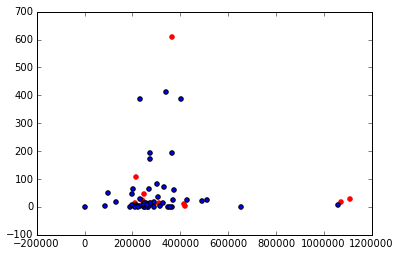

In [47]:
plt.scatter(df_t['salary'],df_t['from_this_person_to_poi'], color='red')
plt.scatter(df_f['salary'],df_f['from_this_person_to_poi'])

In [114]:
df.drop(['TOTAL'])

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,13868,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,56301,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,11200,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,129142,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN
BAZELIDES PHILIP J,80818,NaN,684694,860136,1599641,NaN,NaN,NaN,NaN,1599641,NaN,NaN,NaN,874,NaN,False,NaN,NaN,93750,NaN,NaN
BECK SALLY W,231330,7315,NaN,969068,NaN,700000,126027,2639,NaN,126027,37172,NaN,4343,566,386,False,NaN,NaN,NaN,sally.beck@enron.com,144
BELDEN TIMOTHY N,213999,7991,2144013,5501630,953136,5249999,157569,5521,NaN,1110705,17355,NaN,484,210698,108,True,NaN,-2334434,NaN,tim.belden@enron.com,228
BELFER ROBERT,NaN,NaN,-102500,102500,3285,NaN,NaN,NaN,44093,-44093,NaN,NaN,NaN,NaN,NaN,False,3285,NaN,NaN,NaN,NaN
BERBERIAN DAVID,216582,NaN,NaN,228474,1624396,NaN,869220,NaN,NaN,2493616,11892,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,david.berberian@enron.com,NaN


In [107]:
df.index

Index([u'ALLEN PHILLIP K', u'BADUM JAMES P', u'BANNANTINE JAMES M', u'BAXTER JOHN C', u'BAY FRANKLIN R', u'BAZELIDES PHILIP J', u'BECK SALLY W', u'BELDEN TIMOTHY N', u'BELFER ROBERT', u'BERBERIAN DAVID', u'BERGSIEKER RICHARD P', u'BHATNAGAR SANJAY', u'BIBI PHILIPPE A', u'BLACHMAN JEREMY M', u'BLAKE JR. NORMAN P', u'BOWEN JR RAYMOND M', u'BROWN MICHAEL', u'BUCHANAN HAROLD G', u'BUTTS ROBERT H', u'BUY RICHARD B', u'CALGER CHRISTOPHER F', u'CARTER REBECCA C', u'CAUSEY RICHARD A', u'CHAN RONNIE', u'CHRISTODOULOU DIOMEDES', u'CLINE KENNETH W', u'COLWELL WESLEY', u'CORDES WILLIAM R', u'COX DAVID', u'CUMBERLAND MICHAEL S', u'DEFFNER JOSEPH M', u'DELAINEY DAVID W', u'DERRICK JR. JAMES V', u'DETMERING TIMOTHY J', u'DIETRICH JANET R', u'DIMICHELE RICHARD G', u'DODSON KEITH', u'DONAHUE JR JEFFREY M', u'DUNCAN JOHN H', u'DURAN WILLIAM D', u'ECHOLS JOHN B', u'ELLIOTT STEVEN', u'FALLON JAMES B', u'FASTOW ANDREW S', u'FITZGERALD JAY L', u'FOWLER PEGGY', u'FOY JOE', u'FREVERT MARK A', u'FUGH JOHN L', 